# Load Libraries

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np # CPU libraries
import json 
import cupy, cudf # GPU libraries
import matplotlib.pyplot as plt, gc, os

print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


In [2]:
# VERSION NAME FOR SAVED MODEL FILES
VER = 1

# TRAIN RANDOM SEED
SEED = 42

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

# FOLDS PER MODEL
FOLDS = 5

# Process and Feature Engineer Train Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][3] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [ ]:
with open('../input/amex-cols/col_dict (1).json', 'r') as pf:
    col_dict = json.load(pf)

col_dict.keys()

In [ ]:
skip_cols = list(set(col_dict['drop -1'])|set(col_dict['drop nan'])|set(col_dict['drop 0']))
use_cols = ['customer_ID', 'S_2']+col_dict['usable']

In [3]:
def read_file(path = '', usecols = None):
    # LOAD DATAFRAME
    if usecols is not None: df = cudf.read_parquet(path, columns=usecols)
    else: df = cudf.read_parquet(path)
    # REDUCE DTYPE FOR CUSTOMER AND DATE
    df['customer_ID'] = df['customer_ID'].str[-16:].str.hex_to_int().astype('int64')

    df.S_2 = cudf.to_datetime( df.S_2 )
    df['S_20'] = df.S_2.dt.month
    df['S_21'] = df.S_2.dt.dayofweek
    
    # SORT BY CUSTOMER AND DATE (so agg('last') works correctly)
    df = df.sort_values(['customer_ID','S_2'])
    #df = df.reset_index(drop=True)
    df.drop(columns=['S_2'], inplace=True)
    # FILL NAN
    df = df.fillna(NAN_VALUE) 
    print('shape of data:', df.shape)
    
    return df


In [ ]:
print('Reading train data...')
TRAIN_PATH = '../input/amex-data-integer-dtypes-parquet-format/train.parquet'
train = read_file(path = TRAIN_PATH, usecols=use_cols)

In [ ]:
train.head()

In [4]:
def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_117","D_120","D_126","D_63","D_64","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = cudf.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )
    
    return df

# train = process_and_feature_engineer(train)

In [ ]:
train = process_and_feature_engineer(train)

In [ ]:
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets.head()

In [ ]:
# ADD TARGETS
targets = cudf.read_csv('../input/amex-default-prediction/train_labels.csv')
targets['customer_ID'] = targets['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
targets = targets.set_index('customer_ID')
train = train.merge(targets, left_index=True, right_index=True, how='left')
train.target = train.target.astype('int8')
del targets
# train['customer_ID'] = train['customer_ID'].str[-16:].str.hex_to_int().astype('int64')

# NEEDED TO MAKE CV DETERMINISTIC (cudf merge above randomly shuffles rows)
train = train.sort_index().reset_index()

# FEATURES
FEATURES = train.columns[1:-1]
print(f'There are {len(FEATURES)} features!')

In [ ]:
train.head()

In [ ]:
with open("./FEATURES.json", 'w') as pf:
    json.dump({"FEATURES": list(FEATURES)}, pf)

# Train XGB
We will train using `DeviceQuantileDMatrix`. This has a very small GPU memory footprint.

In [5]:
# LOAD XGB LIBRARY
from sklearn.model_selection import KFold
import xgboost as xgb
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':SEED
}

XGB Version 1.6.1


In [6]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = cudf.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [7]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [ ]:
importances = []
oof = []
train = train.to_pandas() # free GPU memory
TRAIN_SUBSAMPLE = 1.0
gc.collect()

skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            train, train.target )):
    
    # TRAIN WITH SUBSAMPLE OF TRAIN FOLD DATA
    if TRAIN_SUBSAMPLE<1.0:
        np.random.seed(SEED)
        train_idx = np.random.choice(train_idx, 
                       int(len(train_idx)*TRAIN_SUBSAMPLE), replace=False)
        np.random.seed(None)
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with {int(TRAIN_SUBSAMPLE*100)}% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    Xy_train = IterLoadForDMatrix(train.loc[train_idx], FEATURES, 'target')
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, 'target']
    
    dtrain = xgb.DeviceQuantileDMatrix(Xy_train, max_bin=256)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    
    # TRAIN MODEL FOLD K
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'XGB_v{VER}_fold{fold}.xgb')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.get_score(importance_type='weight')
    df = pd.DataFrame({'feature':dd.keys(),f'importance_{fold}':dd.values()})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict(dvalid)
    acc = amex_metric_mod(y_valid.values, oof_preds)
    print('Kaggle Metric =',acc,'\n')
    
    # SAVE OOF
    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_pred'] = oof_preds
    oof.append( df )
    
    del dtrain, Xy_train, dd, df
    del X_valid, y_valid, dvalid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_mod(oof.target.values, oof.oof_pred.values)
print('OVERALL CV Kaggle Metric =',acc)

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

# Save OOF Preds

In [ ]:
oof_xgb = pd.read_parquet(TRAIN_PATH, columns=['customer_ID']).drop_duplicates()
oof_xgb['customer_ID_hash'] = oof_xgb['customer_ID'].apply(lambda x: int(x[-16:],16) ).astype('int64')
oof_xgb = oof_xgb.set_index('customer_ID_hash')
oof_xgb = oof_xgb.merge(oof, left_index=True, right_index=True)
oof_xgb = oof_xgb.sort_index().reset_index(drop=True)
oof_xgb.to_csv(f'oof_xgb_v{VER}.csv',index=False)
oof_xgb.head()

In [ ]:
# PLOT OOF PREDICTIONS
plt.hist(oof_xgb.oof_pred.values, bins=100)
plt.title('OOF Predictions')
plt.show()

In [ ]:
# CLEAR VRAM, RAM FOR INFERENCE BELOW
del oof_xgb, oof
_ = gc.collect()

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt

df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'xgb_feature_importance_v{VER}.csv',index=False)

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Process and Feature Engineer Test Data
We will load @raddar Kaggle dataset from [here][1] with discussion [here][2]. Then we will engineer features suggested by @huseyincot in his notebooks [here][1] and [here][4]. We will use [RAPIDS][5] and the GPU to create new features quickly.

[1]: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format
[2]: https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514
[3]: https://www.kaggle.com/code/huseyincot/amex-catboost-0-793
[4]: https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
[5]: https://rapids.ai/

In [9]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 10
TEST_PATH = '../input/amex-data-integer-dtypes-parquet-format/test.parquet'

print(f'Reading test data...')
test = read_file(path = TEST_PATH, usecols = ['customer_ID','S_2'])
# test['customer_ID'] = test['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
# customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
customers = test['customer_ID'].unique()
# test = test.sort_values(by=['customer_ID'])
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

Reading test data...
shape of data: (11363762, 3)
We will process test data as 10 separate parts.
There will be 92462 customers in each part (except the last part).
Below are number of rows in each part:
[1136059, 1135980, 1136098, 1136825, 1136206, 1136299, 1137604, 1136586, 1135635, 1136470]


In [10]:
customers.shape

(924621,)

In [11]:
test.head()

,customer_ID,S_20,S_21
5468998,-9223277493928322471,4,0
5468999,-9223277493928322471,5,3
5469000,-9223277493928322471,6,4
5469001,-9223277493928322471,7,1
5469002,-9223277493928322471,8,4


In [12]:
test.shape

(11363762, 3)

# Infer Test

In [14]:
with open('./FEATURES.json', 'r') as pf:
    FEATURES = json.load(pf)['FEATURES']

In [15]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test = read_file(path = TEST_PATH)
#     test['customer_ID'] = test['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
#     test = test.set_index('customer_ID')
    test = test.iloc[skip_rows:skip_rows+rows[k]]
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    test = process_and_feature_engineer(test)
    
    
    if k==NUM_PARTS-1: test = test.loc[customers[skip_cust:]]
    else: test = test.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
    
    # TEST DATA FOR XGB
    X_test = test[FEATURES]
    dtest = xgb.DMatrix(data=X_test)
    del X_test
    gc.collect()

    # INFER XGB MODELS ON TEST DATA
    model = xgb.Booster()
    model.load_model(f'XGB_v{VER}_fold0.xgb')
    preds = model.predict(dtest)
    for f in range(1,FOLDS):
        model.load_model(f'XGB_v{VER}_fold{f}.xgb')
        preds += model.predict(dtest)
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del dtest, model
    _ = gc.collect()


Reading test data...
shape of data: (11363762, 190)
=> Test part 1 has shape (1136059, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 2 has shape (1135980, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 3 has shape (1136098, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 4 has shape (1136825, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 5 has shape (1136206, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 6 has shape (1136299, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 7 has shape (1137604, 190)
shape after engineering (92462, 927)

Reading test data...
shape of data: (11363762, 190)
=> Test part 8 has shape (1136586, 19

In [18]:
np.concatenate(test_preds).shape

(924621,)

In [19]:
customers.shape

(924621,)

# Create Submission CSV

In [ ]:
print(test[['prediction']].shape, sub.shape)

In [ ]:
sub.head()

In [ ]:
test.head()

In [ ]:
test_preds.shape

In [ ]:
print(test['customer_ID'].uniques().shape, test_preds1.shape)

In [20]:
# WRITE SUBMISSION FILE
test_preds1 = np.concatenate(test_preds)
test = cudf.DataFrame(index=customers, data={'prediction':test_preds1})
sub = cudf.read_csv('../input/amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].str[-16:].str.hex_to_int().astype('int64')
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_xgb_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,0f7f94e1247f12d2a38fb2b014d6be7175f51b3b4efe9b...,0.043651
1,0f8086f7297593825bba8c654ea9d35f661089ce25ed79...,0.094701
2,0f7fe57b8ce23fdd299b99cbcf7fac47e0cdf6459bb616...,0.081435
3,0f81168c4911b484975ff222f75321396c546b700fa329...,0.041761
4,0f7f94e3f0e63573b61dccc9fb3c4091ccc8d283d7b58a...,0.013506


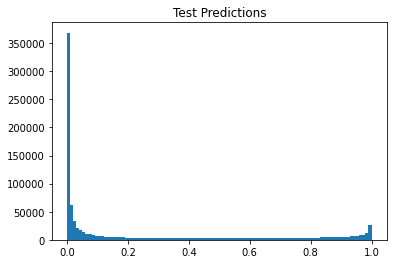

In [21]:
# PLOT PREDICTIONS
plt.hist(sub.to_pandas().prediction, bins=100)
plt.title('Test Predictions')
plt.show()